In [10]:
# import necessary libraries and set up the grid
import matplotlib.pyplot as plt
import numpy as np
import random as rd
from mpl_toolkits.mplot3d import Axes3D

# the number of cells in the x and y directions and the number of time steps
nx = 20
ny = 20
nz = 20
nt = 100

neighbour_range  = 1 # the range of the neighbourhood
round_inf = (neighbour_range*2+1)**3 

# the initial state of the cells
male_init_number = 700
female_init_number = 700
prey_init_number = 1200
predator_init_number = 0

male_array = []
female_array = []
prey_array = []
predator_array = []

picture_style = "grey"

* 食物增多时：体重越重，雄性占比减少
* 密度（丰度）越高：体重越小，雄性增多

In [11]:
# the SET of rules for the simulation


def inRange(l, r, key):
    if l <= key and key <= r:
        return True
    else:
        return False


# 存在概率修正
def nextCellLampary(countResult, state, flag):
    alive_lampary = countResult[0] + countResult[1]
    if flag == "lampary":
        if state == 0:
            if (
                inRange(1, 4, alive_lampary)
                and inRange(alive_lampary, round_inf, countResult[2])
                and inRange(-round_inf, 3, countResult[3])
            ):
                female_probability = 0.4 + 0.1 * (countResult[2] - alive_lampary)
                if rd.random() > female_probability:
                    return 1
                else:
                    return 2
            else:
                return 0

        elif state == 1:
            if (
                inRange(1, 5, alive_lampary)
                and inRange(alive_lampary - 1, round_inf, countResult[2])
                and inRange(-round_inf, 3, countResult[3])
            ):
                female_probability = 0.1 * (countResult[2] - alive_lampary)
                if rd.random() > female_probability:
                    return 1
                else:
                    return 2
            else:
                return 0

        elif state == 2:
            if (
                inRange(1, 5, alive_lampary)
                and inRange(alive_lampary - 1, round_inf, countResult[2])
                and inRange(-round_inf, 3, countResult[3])
            ):
                female_probability = 0.5 + 0.1 * (countResult[2] - alive_lampary)
                if rd.random() > female_probability:
                    return 1
                else:
                    return 2
            else:
                return 0

        else:
            print("state is wrong")
            exit(1)

    elif flag == "prey":
        if state == 0:
            if inRange(-round_inf, 2, alive_lampary) and inRange(1, 3, countResult[2]):
                return 1
            else:
                return 0
        elif state == 1:
            if inRange(-round_inf, 3, alive_lampary) and inRange(2, 4, countResult[2]):
                return 1
            else:
                return 0
        else:
            print("state is wrong")
            exit(1)

    elif flag == "predator":
        if state == 0:
            if inRange(countResult[3] + 1, round_inf, alive_lampary) and inRange(
                2, alive_lampary + 1, countResult[3]
            ):
                return 1
            else:
                return 0
        elif state == 1:
            if inRange(countResult[3], round_inf, alive_lampary) and inRange(
                1, alive_lampary + 1, countResult[3]
            ):
                return 1
            else:
                return 0
        else:
            print("state is wrong")
            exit(1)

    else:
        print("flag is wrong")
        exit(1)

In [12]:
class cellState:
    # initialize the state of the cells
    def __init__(self, nx, ny, nz):
        self.nx = nx
        self.ny = ny
        self.nz = nz

        self.lampreys = np.zeros(
            (nx, ny, nz)
        )  # 0 = dead, 1 = alive male, 2 = alive female,
        self.prey = np.zeros((nx, ny, nz))  # 0 = dead, 1 = alive
        self.predator = np.zeros((nx, ny, nz))  # 0 = dead, 1 = alive

        self.lampreys_male_alive = 0
        self.lampreys_female_alive = 0
        self.prey_alive = 0
        self.predator_alive = 0

    # set the initial state of the cells
    def random_lampreys(self, total_number_1, total_number_2):
        # 随机生成 total_number_1 个 1
        for _ in range(total_number_1):
            while True:
                i, j, k = (
                    rd.randint(0, self.nx - 1),
                    rd.randint(0, self.ny - 1),
                    rd.randint(0, self.nz - 1),
                )
                if self.lampreys[i][j][k] == 0:
                    self.lampreys[i][j][k] = 1
                    self.lampreys_male_alive += 1
                    break
        # 随机生成 total_number_2 个 2
        for _ in range(total_number_2):
            while True:
                i, j, k = (
                    rd.randint(0, self.nx - 1),
                    rd.randint(0, self.ny - 1),
                    rd.randint(0, self.nz - 1),
                )
                if self.lampreys[i][j][k] == 0:
                    self.lampreys[i][j][k] = 2
                    self.lampreys_female_alive += 1
                    break

    # set the initial state of the cells
    def random_prey(self, total_number):
        # 随机生成 total_number 个 1
        count = 0
        while count < total_number:
            i, j, k = (
                rd.randint(0, self.nx - 1),
                rd.randint(0, self.ny - 1),
                rd.randint(0, self.nz - 1),
            )
            if self.prey[i][j][k] == 0:
                self.prey[i][j][k] = 1
                self.prey_alive += 1
                count += 1

    # set the initial state of the cells
    def random_predator(self, total_number):
        # 随机生成 total_number 个 1
        count = 0
        while count < total_number:
            i, j, k = (
                rd.randint(0, self.nx - 1),
                rd.randint(0, self.ny - 1),
                rd.randint(0, self.nz - 1),
            )
            if self.predator[i][j][k] == 0:
                self.predator[i][j][k] = 1
                self.predator_alive += 1
                count += 1

    # plot the state of the cells
    def plot_state(self, style, step):
        # 创建一个3D图形对象
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
        # 获取矩阵的维度
        depth, rows, cols = self.lampreys.shape
        # lamprey draw
        for i in range(depth):
            for j in range(rows):
                for k in range(cols):
                    if self.lampreys[i, j, k] == 10:
                        ax.scatter(i, j, k, c="r", marker="o")
                    elif self.lampreys[i, j, k] == 1:
                        ax.scatter(i, j, k, c="b", marker="o")
                    elif self.lampreys[i, j, k] == 2:
                        ax.scatter(i, j, k, c="g", marker="o")
        # 设置坐标轴标签
        ax.axis("off")
        # 显示图形
        plt.show()

        # prey draw
        for i in range(depth):
            for j in range(rows):
                for k in range(cols):
                    if self.prey[i, j, k] == 0:
                        ax.scatter(i, j, k, c="b", marker="o")
                    elif self.prey[i, j, k] == 1:
                        ax.scatter(i, j, k, c="r", marker="^")

        # 设置坐标轴标签
        ax.axis("off")
        # 显示图形
        plt.show()

        # predator draw
        for i in range(depth):
            for j in range(rows):
                for k in range(cols):
                    if self.predator[i, j, k] == 0:
                        ax.scatter(i, j, k, c="b", marker="o")
                    elif self.predator[i, j, k] == 1:
                        ax.scatter(i, j, k, c="r", marker="^")
        # 设置坐标轴标签
        ax.set_xlabel("X Label")
        ax.set_ylabel("Y Label")
        ax.set_zlabel("Z Label")
        # 显示图形
        plt.show()

        print("step: ", step)
        print("Lampreys  male  alive: ", self.lampreys_male_alive)
        print("Lampreys female alive: ", self.lampreys_female_alive)
        print("Prey            alive: ", self.prey_alive)
        print("Predator        alive: ", self.predator_alive)
        print("-----------------------------------")
        print("\n")

    # judge the state of the cells
    def countCellState(self, i, j, k):
        alive_male_neighbors = 0
        alive_female_neighbors = 0
        prey_neighbors = 0
        predator_neighbors = 0

        # for the edge, we assume that the top is connected to the bottom, and the left is connected to the right
        for x in range(-neighbour_range, neighbour_range + 1):
            for y in range(-neighbour_range, neighbour_range + 1):
                for z in range(-neighbour_range, neighbour_range + 1):
                    if self.lampreys[(i + x) % nx, (j + y) % ny, (k + z) % nz] == 1:
                        alive_male_neighbors += 1
                    elif self.lampreys[(i + x) % nx, (j + y) % ny, (k + z) % nz] == 2:
                        alive_female_neighbors += 1
                    elif self.prey[(i + x) % nx, (j + y) % ny, (k + z) % nz] == 1:
                        prey_neighbors += 1
                    elif self.predator[(i + x) % nx, (j + y) % ny, (k + z) % nz] == 1:
                        predator_neighbors += 1

        result = (
            alive_male_neighbors,
            alive_female_neighbors,
            prey_neighbors,
            predator_neighbors,
        )
        return result

    # update the state of the cells
    def updateState(self):
        new_lampreys = np.zeros((self.nx, self.ny, self.nz))
        new_prey = np.zeros((self.nx, self.ny, self.nz))
        new_predator = np.zeros((self.nx, self.ny, self.nz))
        new_male_alive = 0
        new_female_alive = 0
        new_prey_alive = 0
        new_predator_alive = 0

        # for the lampreys
        for i in range(self.nx):
            for j in range(self.ny):
                for k in range(self.nz):
                    new_lampreys[i][j][k] = nextCellLampary(
                        self.countCellState(i, j, k), self.lampreys[i][j][k], "lampary"
                    )
                    if new_lampreys[i][j][k] == 1:
                        new_male_alive += 1
                    elif new_lampreys[i][j][k] == 2:
                        new_female_alive += 1

        self.lampreys = new_lampreys.copy()
        self.lampreys_male_alive = new_male_alive
        self.lampreys_female_alive = new_female_alive

        # for the prey and the predator
        for i in range(self.nx):
            for j in range(self.ny):
                for k in range(self.nz):
                    new_prey[i][j][k] = nextCellLampary(
                        self.countCellState(i, j, k), self.prey[i][j][k], "prey"
                    )
                    if new_prey[i][j][k] == 1:
                        new_prey_alive += 1
                    new_predator[i][j][k] = nextCellLampary(
                        self.countCellState(i, j, k), self.predator[i][j][k], "predator"
                    )
                    if new_predator[i][j][k] == 1:
                        new_predator_alive += 1

        self.prey = new_prey.copy()
        self.prey_alive = new_prey_alive
        self.predator = new_predator.copy()
        self.predator_alive = new_predator_alive

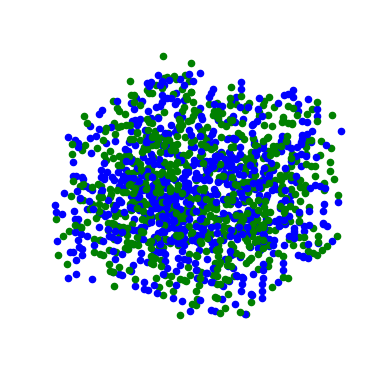

step:  -1
Lampreys  male  alive:  700
Lampreys female alive:  700
Prey            alive:  1200
Predator        alive:  0
-----------------------------------




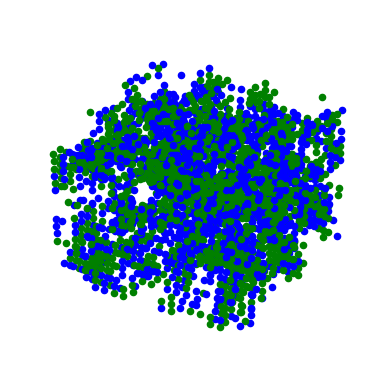

step:  0
Lampreys  male  alive:  1338
Lampreys female alive:  1478
Prey            alive:  623
Predator        alive:  0
-----------------------------------




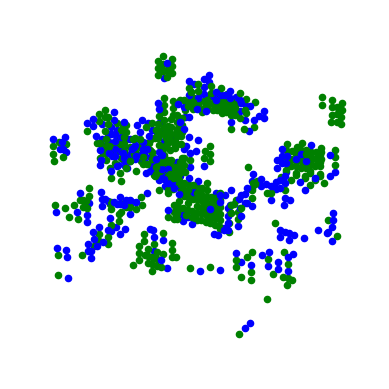

step:  20
Lampreys  male  alive:  297
Lampreys female alive:  466
Prey            alive:  249
Predator        alive:  0
-----------------------------------




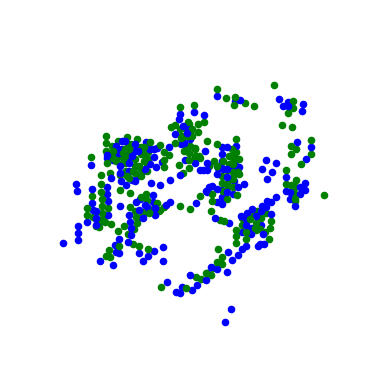

step:  40
Lampreys  male  alive:  213
Lampreys female alive:  230
Prey            alive:  302
Predator        alive:  0
-----------------------------------




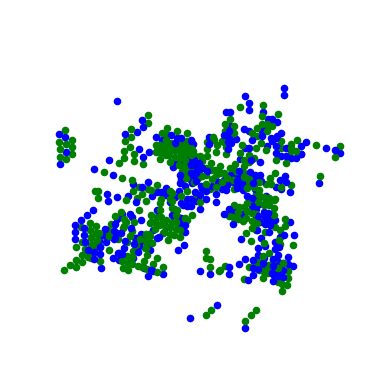

step:  60
Lampreys  male  alive:  321
Lampreys female alive:  391
Prey            alive:  258
Predator        alive:  0
-----------------------------------




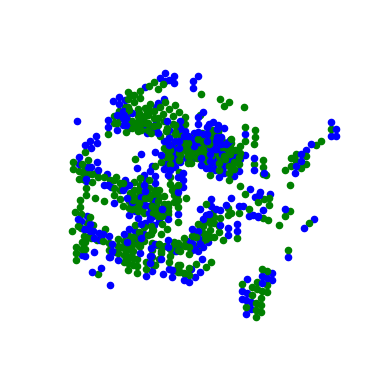

step:  80
Lampreys  male  alive:  316
Lampreys female alive:  468
Prey            alive:  307
Predator        alive:  0
-----------------------------------


The end of the simulation


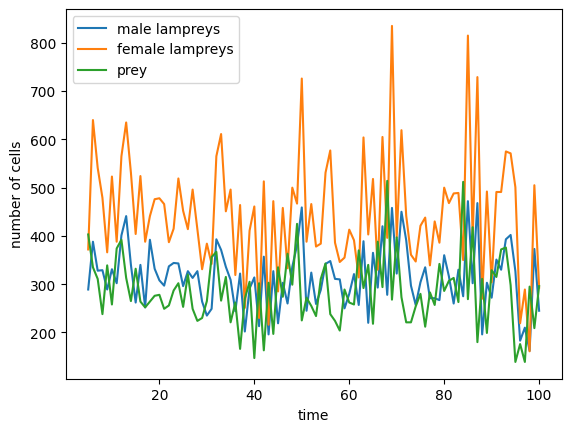

In [13]:
# main function
if __name__ == "__main__":
    state = cellState(nx, ny, nz)
    state.random_lampreys(male_init_number, female_init_number)
    state.random_prey(prey_init_number)
    state.random_predator(predator_init_number)
    state.plot_state(picture_style, -1)

    male_array.append(state.lampreys_male_alive)
    female_array.append(state.lampreys_female_alive)
    prey_array.append(state.prey_alive)
    predator_array.append(state.predator_alive)

    for i in range(0, nt):
        state.updateState()

        male_array.append(state.lampreys_male_alive)
        female_array.append(state.lampreys_female_alive)
        prey_array.append(state.prey_alive)
        predator_array.append(state.predator_alive)

        if i % 20 == 0:
            state.plot_state(picture_style, i)
            if (
                state.lampreys_female_alive
                + state.lampreys_male_alive
                + state.prey_alive
                + state.predator_alive
                > 3 * nx * ny * nz
            ):
                print("Error: the number of cells is not conserved")
                break

    print("The end of the simulation")
    
    # plot the trend of the number of cells
    plt.plot(range(5, nt + 1), male_array[5:], label="male lampreys")
    plt.plot(range(5, nt + 1), female_array[5:], label="female lampreys")
    plt.plot(range(5, nt + 1), prey_array[5:], label="prey")
    #plt.plot(range(0, nt + 1), predator_array, label="predator")
    plt.xlabel("time")
    plt.ylabel("number of cells")
    plt.legend()
    plt.show()

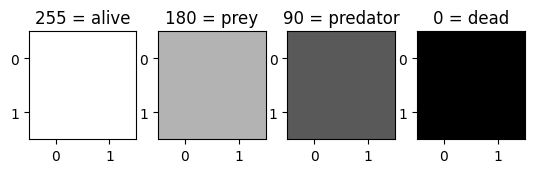

In [14]:
# plot the color bar
_255array = np.full((2, 2), 255)
_180array = np.full((2, 2), 180)
_90array = np.full((2, 2), 90)
_0array = np.zeros((2, 2))

plt.subplot(1, 4, 1, title="255 = alive")
plt.imshow(_255array, cmap=picture_style, vmin=0, vmax=255)
plt.subplot(1, 4, 2, title="180 = prey")
plt.imshow(_180array, cmap=picture_style, vmin=0, vmax=255)
plt.subplot(1, 4, 3, title="90 = predator")
plt.imshow(_90array, cmap=picture_style, vmin=0, vmax=255)
plt.subplot(1, 4, 4, title="0 = dead")
plt.imshow(_0array, cmap=picture_style, vmin=0, vmax=255)
plt.show()